In [1]:
import numpy as np
from cluster_sim.app.grid import Grid
from cluster_sim.app.utils import get_node_coords

import os
from joblib import delayed
import time
from analysis_funcs import algorithm1, apply_error_channel, ParallelTqdm
import networkx as nx

os.makedirs("./data", exist_ok=True)

shape = [20, 20, 200]
seed = 12345

samples = 1

# The probabilities to simulate
p_vec = np.linspace(0, 0.7, 20)

# Input vector for all jobs
jobs_input_vec = p_vec

In [2]:
def main(input_params):
    """
    Main function for parallel processing. Here, we:

    1. Create a grid of the given shape
    2. Apply the error channel to the grid
    3. Generate a RHG lattice
    4. Check for path percolation
    5. Return the results

    Returns:
        - p: The input parameter for the simulation
        - percolates: The number of times percolation occurred (True: 1, False: 0)
        - times: The average time taken for the simulation
    """
    
    p = input_params

    # Sanity check: check that this is equal to the move_list on the app
    # print(np.reshape(np.argwhere(removed_nodes == True), shape=-1))
    
    percolates = 0
    
    times = np.zeros(samples)
    diffs = np.zeros(samples)
    for i in range(samples):
        start = time.time()
        G = Grid(shape)
        removed_nodes = np.zeros(shape[0] * shape[1] * shape[2], dtype=bool)

        G, D, removed_nodes = apply_error_channel(p, seed + i, shape, removed_nodes, G)

        # Generate an RHG lattice out of G
        G, removed_nodes, offsets = algorithm1(G, D, removed_nodes, shape)

        xoffset, yoffset, _ = offsets

        # Check if the largest cluster percolates
        low = np.array([np.inf, np.inf, np.inf])
        high = np.zeros(3)

        gnx = G.to_networkx()

        largest_cc = max(nx.connected_components(gnx), key=len)
        largest_cc = gnx.subgraph(largest_cc).copy()

        for node in largest_cc.nodes:
            # Get the coordinates of the node

            low = np.minimum(low, get_node_coords(node, shape))
            high = np.maximum(high, get_node_coords(node, shape))
        # print(diffs[i], low, high)
        diffs[i] = high[2] - low[2] 

        #print(f"high = {high}, low={low}, diff={diff}")
        if shape[2] - diffs[i] <= 3:
            percolates += 1

        times[i] = time.time() - start 

    return (p, percolates, diffs.mean(), times.mean())


In [3]:
results = ParallelTqdm(n_jobs=-1)([delayed(main)(x) for x in jobs_input_vec])
results = np.array(results)


100%|██████████| 20/20 [00:05<00:00,  3.67tasks/s]


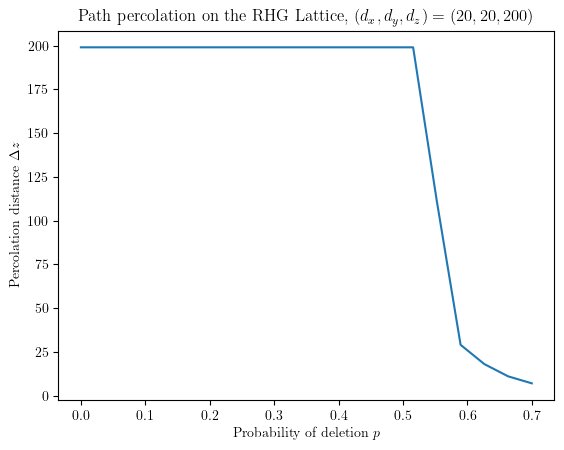

Exception ignored in: <function ResourceTracker.__del__ at 0x10587a980>
Traceback (most recent call last):
  File "/Users/zhihan/miniconda3/envs/mbqc/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/zhihan/miniconda3/envs/mbqc/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/zhihan/miniconda3/envs/mbqc/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10637a980>
Traceback (most recent call last):
  File "/Users/zhihan/miniconda3/envs/mbqc/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/zhihan/miniconda3/envs/mbqc/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/zhihan/miniconda3/envs/mbqc/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No 

In [4]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern']    
    })

plt.plot(results[:, 0], results[:, 2])
plt.xlabel(r"Probability of deletion $p$")
plt.ylabel(r"Percolation distance $\Delta z$")
plt.title(r"Path percolation on the RHG Lattice, $(d_x, d_y, d_z)=(20, 20, 200)$")
plt.savefig(f"data/path_percolation_rhg{samples}.pdf", dpi=300)